In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

df = pd.read_parquet('../data/rucphen_precipitation_clean.parquet')
df

,timestamp,precipitation,percentage
0,2019-01-01 00:00:00,0.000000,7.895
1,2019-01-01 00:05:00,0.000000,7.895
2,2019-01-01 00:10:00,0.000000,7.895
3,2019-01-01 00:15:00,0.000000,7.895
4,2019-01-01 00:20:00,0.000000,7.895
...,...,...,...
498217,2023-10-12 23:35:00,0.010010,2.632
498218,2023-10-12 23:40:00,0.039978,2.632
498219,2023-10-12 23:45:00,0.049988,2.632
498220,2023-10-12 23:50:00,0.039978,2.632


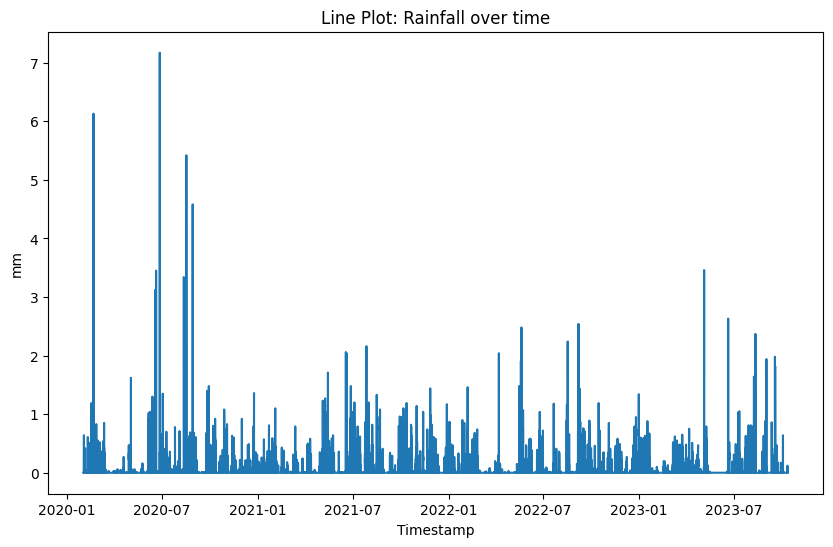

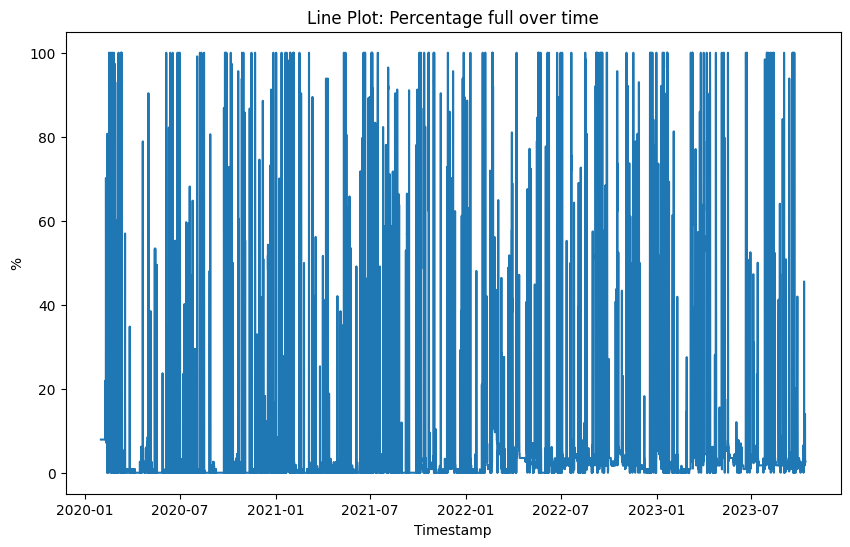

In [3]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')
show_df(df)

/tmp/ipykernel_25977/2587407385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


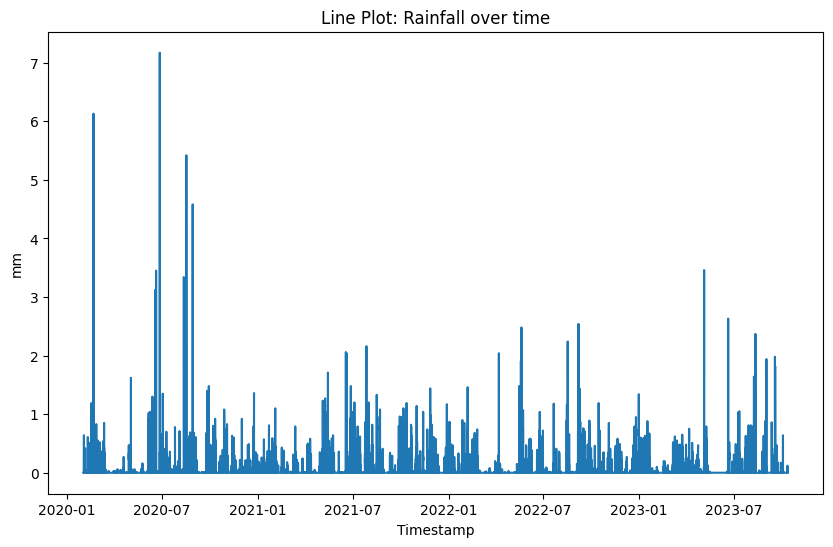

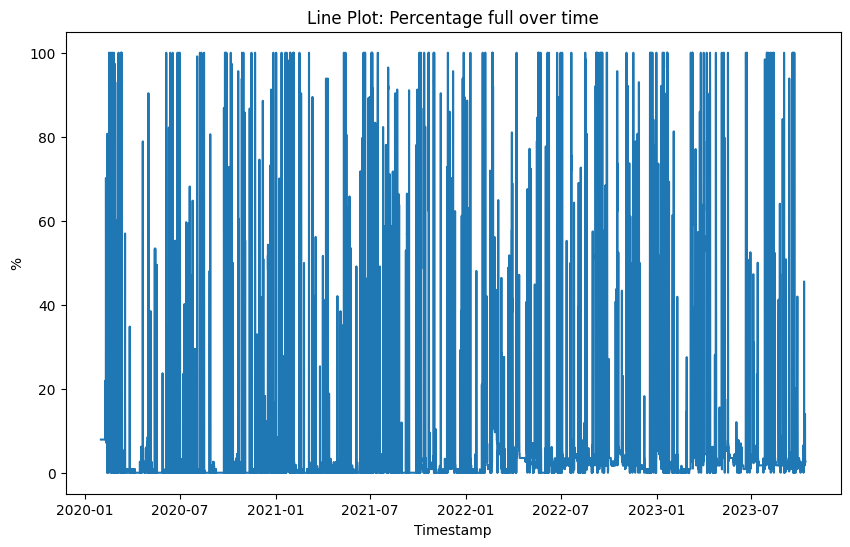

In [4]:
start_timestamp = pd.to_datetime('2020-02-01 08:00:00')
end_timestamp = pd.to_datetime('2023-11-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df = df[mask]
df.fillna(0, inplace=True)
show_df(df)

In [5]:
# Datetime featurs
# Extracting features
df_features = df.copy()
df_features['hour'] = df_features['timestamp'].dt.hour
df_features['dayofweek'] = df_features['timestamp'].dt.dayofweek
df_features['isweekend'] = df_features['timestamp'].dt.weekday >= 5  # True if it's Saturday or Sunday, False otherwise
df_features['month'] = df_features['timestamp'].dt.month

df_features['isweekend'] = df_features['isweekend'].astype(int)
df_features.drop('timestamp', axis=1, inplace=True)

# Lags
# Sort the DataFrame by timestamp
# df = df.sort_values(by='timestamp')

# Define the lags you want
lags = [1, 2, 3, 5]

# Add lag features for 'precipitation'
for lag in lags:
    df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

# Add lag features for 'percentage'
for lag in lags:
    df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

# Drop rows with NaN values introduced by the lag operation
df_features = df_features.dropna()

# Reset index if needed
df_features = df_features.reset_index(drop=True)


df_features.head()

,precipitation,percentage,hour,dayofweek,isweekend,month,precipitation_lag_1,precipitation_lag_2,precipitation_lag_3,precipitation_lag_5,percentage_lag_1,percentage_lag_2,percentage_lag_3,percentage_lag_5
0,0.0,7.895,8,5,1,2,0.0,0.0,0.0,0.0,7.895,7.895,7.895,7.895
1,0.0,7.895,8,5,1,2,0.0,0.0,0.0,0.0,7.895,7.895,7.895,7.895
2,0.0,7.895,8,5,1,2,0.0,0.0,0.0,0.0,7.895,7.895,7.895,7.895
3,0.0,7.895,8,5,1,2,0.0,0.0,0.0,0.0,7.895,7.895,7.895,7.895
4,0.0,7.895,8,5,1,2,0.0,0.0,0.0,0.0,7.895,7.895,7.895,7.895


In [6]:
# Extract features and target from the DataFrame
X = df_features.loc[:, df_features.columns != 'percentage']
y = df_features['percentage']

# # Convert to PyTorch tensors
# X = torch.tensor(X.values, dtype=torch.float32)
# y = torch.tensor(y.values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM Model
model = svm.SVR(kernel='linear')
model.fit(X_train_scaled, y_train.squeeze())

In [ ]:
# Make Predictions
predictions = model.predict(X_test_scaled)

# Evaluate the Model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse.item()}')